# SAT comparisons

[JR] Running various things here to try and understand SAT optical models,
with larger goal of understanding how to model thin window for S4.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import yaml
from jbolo_funcs import *

k_B = 1.380649e-23 # Boltzmann's constant

# Make inline plots in this notebook, make them reasonable sizes, and with legible font size
%matplotlib inline
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [8,4]

maindir = '/Users/ruhl/code/bolo_calc_runs/jbolo/SO'

# Run a suite of models and look at Trj's and NETs.


In [2]:
# Run a modified bicep3
names = ['B3_orig', 'B3_modified','B3_thin_modified','s4_orig','s4_modified', 's4_thin_modified']
data = {}

for name in names:
    match name:
        case 'B3_orig':
            # Trying to emulate the paper H. Hui is corresponding author for.
            yamlfile = 'yamls/Bicep3_90GHz.yaml'
            sim = yaml.safe_load(open(yamlfile))
        case 'B3_modified':
            # Modified orig model to use use lower tand for window as in Eibert paper, but 
            # add back in the power in the alumina filter and the RTMLI.  Note that their alumina elements have stycast coatings.
            yamlfile = 'yamls/Bicep3_90GHz.yaml'
            sim = yaml.safe_load(open(yamlfile))
            # Modify
            sim['optical_elements']['window']['loss_tangent'] = 1.0e-4
            sim['optical_elements']['alumina_filt']['loss_tangent'] = 5.5e-4
            sim['optical_elements']['alumina_filt']['temperature'] = 70
            sim['optical_elements']['RTMLI_10']['absorption'] = [0.012, 0.012]
            sim['optical_elements']['RTMLI_10']['temperature'] = 175.
        case 'B3_thin_modified':
            # Like B3 modified, but thin window with higher-still loss tangent as in Eibert paper.
            yamlfile = 'yamls/Bicep3_90GHz.yaml'
            sim = yaml.safe_load(open(yamlfile))
            # Modify
            sim['optical_elements']['window']['loss_tangent'] = 4.6e-4
            sim['optical_elements']['window']['thickness'] = 1.4e-3
            sim['optical_elements']['alumina_filt']['loss_tangent'] = 5.5e-4
            sim['optical_elements']['alumina_filt']['temperature'] = 70
            sim['optical_elements']['RTMLI_10']['absorption'] = [0.012, 0.012]
            sim['optical_elements']['RTMLI_10']['temperature'] = 175.
        case 's4_orig':
            # A "not-split-bands" version of S4's original model.
            yamlfile = 'yamls/SAT_HWP_aggr_MF.yaml'
            #yamlfile = 'yamls/SAT_HWP_aggr_20241121_phase2.yaml'
            sim = yaml.safe_load(open(yamlfile))
        case 's4_modified':
            # modifying S4's orig model in same way as B3_modified.
            # Alumina mods may not make sense if not stycast coatings. ?
            yamlfile = 'yamls/SAT_HWP_aggr_MF.yaml'
            #yamlfile = 'yamls/SAT_HWP_aggr_20241121_phase2.yaml'
            sim = yaml.safe_load(open(yamlfile))
            # Modify
            print('hey')
            #sim['optical_elements']['baffle']['absorption']=0.005
            sim['optical_elements']['window']['loss_tangent'] = 1.2e-4    # UHMWPE, not HDPE
            sim['optical_elements']['alumina_filt']['loss_tangent'] = 5.5e-4
            sim['optical_elements']['alumina_filt']['temperature'] = 70
            sim['optical_elements']['RTMLI_10']['absorption'] = [0.012, 0.012]
            sim['optical_elements']['RTMLI_10']['temperature'] = 175.
        case 's4_thin_modified':
            #  S4_modified in same way as B3_thin_modified, ie change window.
            yamlfile = 'yamls/SAT_HWP_aggr_MF.yaml'
            sim = yaml.safe_load(open(yamlfile))
            # Modify
            #sim['optical_elements']['baffle']['absorption']=0.005
            sim['optical_elements']['window']['loss_tangent'] = 4.6e-4
            sim['optical_elements']['window']['thickness'] = 1.4e-3
            sim['optical_elements']['alumina_filt']['loss_tangent'] = 5.5e-4
            sim['optical_elements']['alumina_filt']['temperature'] = 70
            sim['optical_elements']['RTMLI_10']['absorption'] = [0.012, 0.012]
            sim['optical_elements']['RTMLI_10']['temperature'] = 175.

    print(name, yamlfile)
    run_optics(sim)
    run_bolos(sim)
    #name = sim['version']['name']
    if name not in data.keys():
        data[name] = {}
    for ch in ['MF_1', 'MF_2']:
        if ch not in data[name].keys():
            data[name][ch] = {}
        data[name][ch]['sys_bandwidth'] = sim['outputs'][ch]['sys_bandwidth']/1e9
        data[name][ch]['sys_bandcenter'] = sim['outputs'][ch]['sys_bandcenter']/1e9
        data[name][ch]['NET_NC'] = 1e6*sim['outputs'][ch]['NET_NC_total']
        data[name][ch]['NET_NC'] = 1e6*sim['outputs'][ch]['NET_NC_total']
        data[name][ch]['P_opt'] = 1e12*sim['outputs'][ch]['P_opt']
        P_inst = 0
        for element in sim['outputs'][ch]['optics'].keys():
            P_inst += sim['outputs'][ch]['optics'][element]['P_opt']
        data[name][ch]['P_inst'] = 1e12*P_inst
        data[name][ch]['P_window'] = 1e12*sim['outputs'][ch]['optics']['window']['P_opt']
        data[name][ch]['P_atmos']  = 1e12*sim['outputs'][ch]['sources']['atmosphere']['P_opt']
        gain_bandwidth = sim['outputs'][ch]['sys_gain_bw_product']
        data[name][ch]['gain_bw'] = gain_bandwidth/1e9
        data[name][ch]['Trj_inst'] = P_inst/(k_B*gain_bandwidth)
        data[name][ch]['Trj_atmos'] = sim['outputs'][ch]['sources']['atmosphere']['P_opt']/(k_B*gain_bandwidth)
        data[name][ch]['Trj_cmb'] = sim['outputs'][ch]['sources']['cmb']['P_opt']/(k_B*gain_bandwidth)
        data[name][ch]['Trj_window'] = sim['outputs'][ch]['optics']['window']['P_opt']/(k_B*gain_bandwidth)
        data[name][ch]['Trj_tot'] = sim['outputs'][ch]['P_opt']/(k_B*gain_bandwidth)
        data[name][ch]['Trj_baffle'] = sim['outputs'][ch]['optics']['baffle']['P_opt']/(k_B*gain_bandwidth)
        data[name][ch]['Trj_rtmli'] = sim['outputs'][ch]['optics']['RTMLI_10']['P_opt']/(k_B*gain_bandwidth)
        data[name][ch]['Trj_hwp'] = sim['outputs'][ch]['optics']['hwp']['P_opt']/(k_B*gain_bandwidth)
        data[name][ch]['Trj_aluminafilt'] = sim['outputs'][ch]['optics']['alumina_filt']['P_opt']/(k_B*gain_bandwidth)
        
        data[name][ch]['Trj_notwindow'] = data[name][ch]['Trj_inst'] - data[name][ch]['Trj_window']  # non-instrument window loading
        data[name][ch]['Trj_4Kstuff'] = data[name][ch]['Trj_notwindow'] - data[name][ch]['Trj_hwp'] - data[name][ch]['Trj_rtmli'] - data[name][ch]['Trj_baffle']-data[name][ch]['Trj_aluminafilt']

print_optics(sim,'MF_1')
#items = ['P_window','Trj_window','P_inst','Trj_inst','P_atmos','Trj_atmos','P_opt','Trj_tot','NET_NC','gain_bw']

items = ['Trj_cmb','Trj_atmos', 'Trj_baffle','Trj_window','Trj_rtmli','Trj_hwp','Trj_aluminafilt','Trj_4Kstuff','Trj_inst','Trj_tot','NET_NC','gain_bw','sys_bandwidth', 'sys_bandcenter']


#print('name'.ljust(15),end=' ')

print()
for ch in ['MF_1', 'MF_2']:
    print(ch)
    print(' '.ljust(20),end='')
    for name in data.keys():
        print(f'{name.ljust(9)} ',end=' ')
    print()
    
    for item in items:
        print(f'{item.ljust(15)}: ',end='')
        for name in data.keys():
            print(f'{data[name][ch][item]:12.2f}',end=' ')
        print()
    print('------')
  

B3_orig yamls/Bicep3_90GHz.yaml
B3_modified yamls/Bicep3_90GHz.yaml
B3_thin_modified yamls/Bicep3_90GHz.yaml
s4_orig yamls/SAT_HWP_aggr_MF.yaml
hey
s4_modified yamls/SAT_HWP_aggr_MF.yaml
s4_thin_modified yamls/SAT_HWP_aggr_MF.yaml
MF_1
Element            Popt(pW)   Effic  Effic_cumul
detector       :    0.0000     0.6500    1.0000
lowpass        :    0.0000     0.9400    0.6500
lens2          :    0.0002     0.9621    0.6110
lyot           :    0.2647     0.5100    0.5878
lens1          :    0.0001     0.9633    0.2998
nylon_filt     :    0.0015     0.9835    0.2888
alumina_filt   :    0.2391     0.9463    0.2840
hwp            :    0.0127     0.9776    0.2688
RTMLI_10       :    0.2007     0.9880    0.2627
window         :    0.0511     0.9950    0.2596
baffle         :    0.2578     0.9900    0.2583
atmosphere     :    0.7357     0.9680    0.2557
cmb            :    0.0954     0.0000    0.2475
P_opticsonly_total = 1.0279e-12
P_optical_total =  1.8590e-12

MF_1
                    B3_

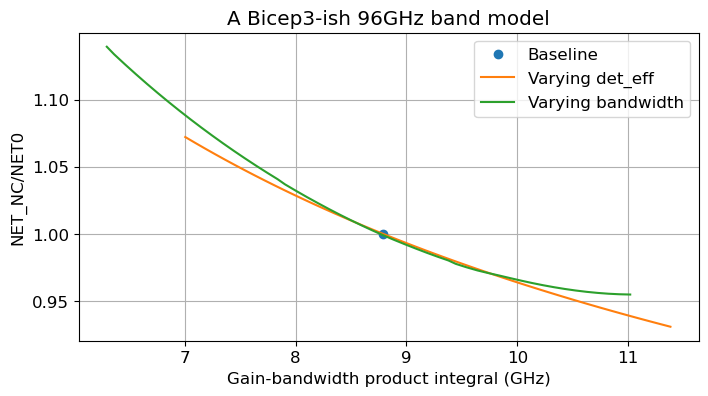

In [4]:
# Run a single model, and see how NET varies with det_eff
sim = yaml.safe_load(open(yamlfile))

######## 
det_eff_vec = np.array([])
NET_vec = np.array([])
gbw_vec = np.array([])
bw_vec = np.array([])

det_eff_vec = np.array([])
NET_vec = np.array([])
gbw_vec = np.array([])
bw_vec = np.array([])

for det_eff in np.linspace(0.4,0.65,50):
    sim['channels']['MF_1']['det_eff'] = det_eff
    run_optics(sim)
    run_bolos(sim)
    det_eff_vec = np.append(det_eff_vec,det_eff)
    NET_vec = np.append(NET_vec,1e6*sim['outputs']['MF_1']['NET_NC_total'])
    bw_vec =  np.append(bw_vec,     sim['outputs']['MF_1']['sys_bandwidth']/1e9)
    gbw_vec = np.append(gbw_vec,    sim['outputs']['MF_1']['sys_gain_bw_product']/1e9)

ii = np.argmin( np.abs(det_eff_vec-0.5) )
NET0 = NET_vec[ii]
plt.plot(gbw_vec[ii], [1],'.',markersize=12,label = 'Baseline')
plt.plot(gbw_vec,NET_vec/NET0,label='Varying det_eff')

##############
yamlfile = 'yamls/Bicep3_90GHz.yaml'
sim = yaml.safe_load(open(yamlfile))

det_eff_vec = np.array([])
NET_vec = np.array([])
gbw_vec = np.array([])
bw_vec = np.array([])

#for det_eff in np.linspace(0.3,0.9,50):
    #sim['channels']['MF_1']['det_eff'] = det_eff

det_eff = sim['channels']['MF_1']['det_eff']
band_center = 96.0
for frac_bw in np.linspace(0.2,0.35,50):
    sim['channels']['MF_1']['nu_low'] = band_center*(1-frac_bw/2.0)
    sim['channels']['MF_1']['nu_high'] = band_center*(1+frac_bw/2.0)
    run_optics(sim)
    run_bolos(sim)
    det_eff_vec = np.append(det_eff_vec,det_eff)
    NET_vec = np.append(NET_vec,1e6*sim['outputs']['MF_1']['NET_NC_total'])
    bw_vec =  np.append(bw_vec,     sim['outputs']['MF_1']['sys_bandwidth']/1e9)
    gbw_vec = np.append(gbw_vec,    sim['outputs']['MF_1']['sys_gain_bw_product']/1e9)
plt.plot(gbw_vec,NET_vec/NET0,label='Varying bandwidth')


plt.xlabel('Gain-bandwidth product integral (GHz)')
plt.ylabel('NET_NC/NET0')
plt.title('A Bicep3-ish 96GHz band model')
plt.legend()
plt.grid()